🐍 Python Executable being used: c:\Users\Varsh V\OneDrive\Desktop\Python\.venv\Scripts\python.exe
✅ Seaborn detected.
Loading data...
First 5 rows:
            timestamp  temperature  humidity  ghi  power_output
0 2020-05-15 00:00:00    25.184316     34.78  0.0           0.0
1 2020-05-15 01:00:00    24.621525     34.30  0.0           0.0
2 2020-05-15 02:00:00    24.936930     33.92  0.0           0.0
3 2020-05-15 03:00:00    25.016309     34.50  0.0           0.0
4 2020-05-15 04:00:00    24.678902     36.38  0.0           0.0

Missing Values:
timestamp       0
temperature     0
humidity        0
ghi             0
power_output    0
dtype: int64

Generating Plot 1: Power Output Over Time...


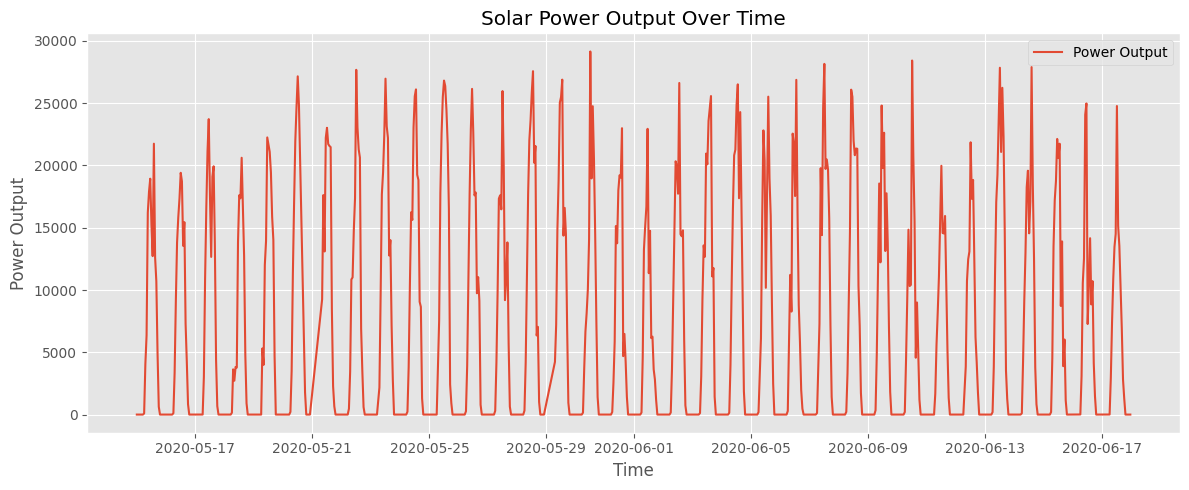

Generating Plot 2: Solar Radiation vs Power...


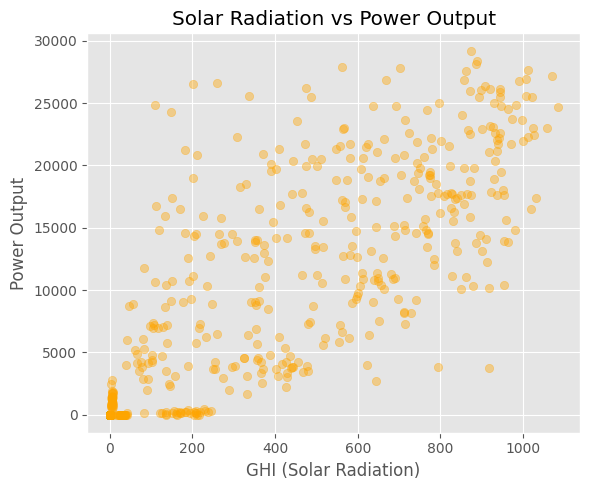

Generating Plot 3: Correlation Heatmap...


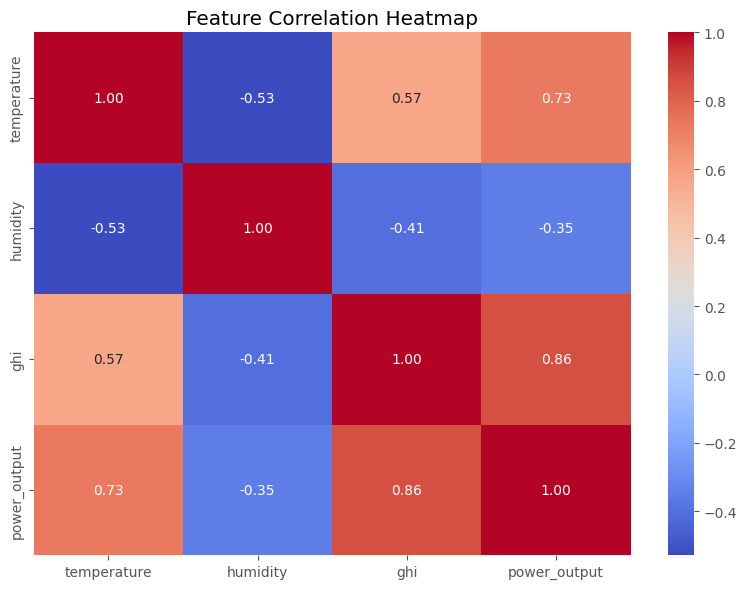

Engineering features...
Features created. New head:
            timestamp  temperature  humidity     ghi  power_output  hour  \
2 2020-05-15 02:00:00    24.936930     33.92    0.00      0.000000     2   
3 2020-05-15 03:00:00    25.016309     34.50    0.00      0.000000     3   
4 2020-05-15 04:00:00    24.678902     36.38    0.00      0.000000     4   
5 2020-05-15 05:00:00    24.177106     37.94   29.05      0.000000     5   
6 2020-05-15 06:00:00    24.088446     33.86  208.57     90.929167     6   

   hour_sin      hour_cos  power_t-1  power_t-2  
2  0.500000  8.660254e-01        0.0        0.0  
3  0.707107  7.071068e-01        0.0        0.0  
4  0.866025  5.000000e-01        0.0        0.0  
5  0.965926  2.588190e-01        0.0        0.0  
6  1.000000  6.123234e-17        0.0        0.0  

Splitting and Scaling data...
Training samples: 630
Testing samples: 158

Training Random Forest Regressor...
------------------------------
MAE:  1405.9637
RMSE: 2768.3849
-----------------

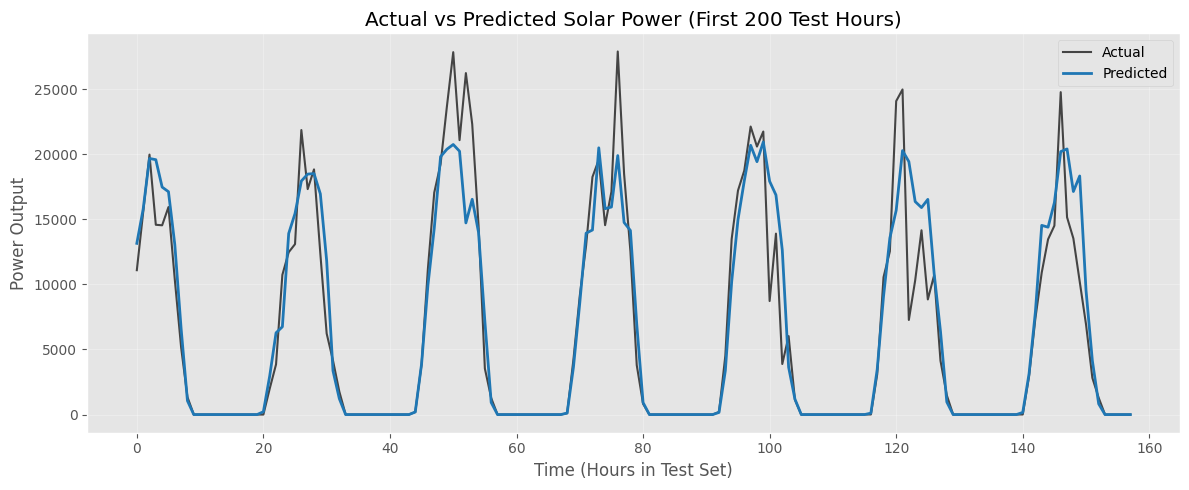


📦 Serialization: Saving model and scaler...
✅ Model saved to:  c:\Users\Varsh V\OneDrive\Desktop\Python\solar-forecast\app\model.joblib
✅ Scaler saved to: c:\Users\Varsh V\OneDrive\Desktop\Python\solar-forecast\app\scaler.joblib


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import joblib  # ✅ Added for model saving

# ==========================================
# 🛠️ DIAGNOSTIC BLOCK
# ==========================================
print(f"🐍 Python Executable being used: {sys.executable}")

# ✅ Robust Seaborn Import with Fix Instructions
try:
    import seaborn as sns
    HAS_SEABORN = True
    print("✅ Seaborn detected.")
except ImportError:
    HAS_SEABORN = False
    print("\n⚠️  Seaborn not found!")
    print(f"   To fix this specific environment, run this command:\n")
    print(f"   \"{sys.executable}\" -m pip install seaborn\n")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set plot style for better aesthetics
plt.style.use('ggplot')

def run_solar_modeling():
    # ==========================================
    # ✅ Step 3: Load Data
    # ==========================================
    print("Loading data...")
    try:
        # Assuming script is in 'notebooks/' and data is in 'data/'
        df = pd.read_csv("../data/final_solar_dataset.csv")
    except FileNotFoundError:
        # Fallback if running from root
        df = pd.read_csv("data/final_solar_dataset.csv")
        
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp")
    
    print("First 5 rows:")
    print(df.head())
    print("\nMissing Values:")
    print(df.isna().sum())

    # ==========================================
    # ✅ Step 4: Plot 1 (Power vs Time)
    # ==========================================
    print("\nGenerating Plot 1: Power Output Over Time...")
    plt.figure(figsize=(12, 5))
    plt.plot(df["timestamp"], df["power_output"], label="Power Output")
    plt.title("Solar Power Output Over Time")
    plt.xlabel("Time")
    plt.ylabel("Power Output")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ==========================================
    # ✅ Step 5: Plot 2 (GHI vs Power)
    # ==========================================
    print("Generating Plot 2: Solar Radiation vs Power...")
    plt.figure(figsize=(6, 5))
    plt.scatter(df["ghi"], df["power_output"], alpha=0.4, c='orange')
    plt.xlabel("GHI (Solar Radiation)")
    plt.ylabel("Power Output")
    plt.title("Solar Radiation vs Power Output")
    plt.tight_layout()
    plt.show()

    # ==========================================
    # ✅ Step 6: Plot 3 (Correlation Heatmap)
    # ==========================================
    print("Generating Plot 3: Correlation Heatmap...")
    if HAS_SEABORN:
        plt.figure(figsize=(8, 6))
        # Select only numeric columns for correlation
        cols_to_corr = ["temperature", "humidity", "ghi", "power_output"]
        sns.heatmap(df[cols_to_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Feature Correlation Heatmap")
        plt.tight_layout()
        plt.show()
    else:
        print(">> Skipping Heatmap (Seaborn missing). See instructions at top of output.")

    # ==========================================
    # ✅ Step 7: Feature Engineering
    # ==========================================
    print("Engineering features...")
    # Cyclical time features
    df["hour"] = df["timestamp"].dt.hour
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    # Lag features (What happened 1 hour and 2 hours ago?)
    df["power_t-1"] = df["power_output"].shift(1)
    df["power_t-2"] = df["power_output"].shift(2)

    # Drop NaNs created by shifting
    df = df.dropna()
    print("Features created. New head:")
    print(df.head())

    # ==========================================
    # ✅ Step 8: Train/Test Split + Scaling
    # ==========================================
    print("\nSplitting and Scaling data...")
    features = ["temperature", "humidity", "ghi", "hour_sin", "hour_cos", "power_t-1", "power_t-2"]
    target = "power_output"

    X = df[features]
    y = df[target]

    # Time-series split (shuffle=False is crucial)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Testing samples: {len(X_test_scaled)}")

    # ==========================================
    # ✅ Step 9: Train Model + Evaluate
    # ==========================================
    print("\nTraining Random Forest Regressor...")
    model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    # Fix: Calculate RMSE using np.sqrt to avoid 'squared' argument errors on older sklearn versions
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("-" * 30)
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("-" * 30)

    # ==========================================
    # ✅ Step 10: Final Prediction Plot
    # ==========================================
    print("Generating Final Plot: Actual vs Predicted...")
    plt.figure(figsize=(12, 5))
    # Plotting first 200 hours of the test set for clarity
    plt.plot(y_test.values[:200], label="Actual", color='black', alpha=0.7)
    plt.plot(y_pred[:200], label="Predicted", color='#1f77b4', linewidth=2)
    plt.legend()
    plt.title("Actual vs Predicted Solar Power (First 200 Test Hours)")
    plt.xlabel("Time (Hours in Test Set)")
    plt.ylabel("Power Output")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ==========================================
    # ✅ Step 11: Save Model & Scaler (NEW)
    # ==========================================
    print("\n📦 Serialization: Saving model and scaler...")
    
    # Check if we are running from 'notebooks/' or root to set correct path
    save_dir = "app"
    if not os.path.exists("data") and os.path.exists("../data"):
        # We are likely in notebooks/, so save to ../app
        save_dir = "../app"
    
    os.makedirs(save_dir, exist_ok=True)
    
    model_path = os.path.join(save_dir, "model.joblib")
    scaler_path = os.path.join(save_dir, "scaler.joblib")
    
    try:
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        print(f"✅ Model saved to:  {os.path.abspath(model_path)}")
        print(f"✅ Scaler saved to: {os.path.abspath(scaler_path)}")
    except Exception as e:
        print(f"❌ Error saving files: {e}")

if __name__ == "__main__":
    run_solar_modeling()